In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
# DESCR: 데이터셋 설명
# data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열
# target: 레이블 배열

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape
# 28x28 = 784개의 feature

((70000, 784), (70000,))

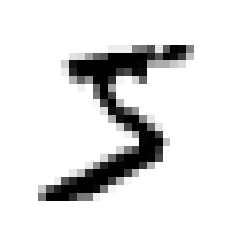

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
# label이 문자열이다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환.
y = y.astype(np.uint8)

In [7]:
# MNIST의 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듬.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# 5만을 식별하는 이진 분류기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
# 확률적 경사 하강법 (Stochastic GD)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [10]:
# cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# 3 fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

# 모든 이미지를 '5 아님'으로 분류했을때 정확도 90% 나옴
# accuracy를 성능 측정 지표로 선호하지 않는 이유
# 불균형한 데이터셋(어떤 클래스가 다른 것보다 월등히 많은 겅우)을 다룰때 더욱 심하다

array([0.91125, 0.90855, 0.90915])

In [13]:
# 오차 행렬 (confusion matrix)
# 클래스 A를 클래스 B로 잘못 분류된 횟수를 세는 것.
# 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수 -> 오차 행렬의 5행 3열

# 먼저 실제 타깃과 비교를 위한 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# 오차 행렬 생성
# 행=실제 클래스, 열=예측한 클래스
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# 첫번째 행 '5 아님' 이미지를 '5 아님'으로 정확히 분류: 53057개, 나머지 1522개는 '5'라고 잘못 분류
# 두번째 행 '5' 이미지를 '5 아님'으로 잘못 분류: 1325개, 나머지 4096개는 정확히 '5'라고 분류
#                    예측
#               음성        양성
#       음성   53892        687
# 실제                             ㅅ
#       양성   1891         3530   | 정밀도
#                    <-재현율

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
# 완벽한 분류기의 경우 진짜 양성과 진짜 음성만 있을 것이므로 오차 행렬의 주대각선만 0이 아님
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [15]:
from sklearn.metrics import precision_score, recall_score

# 정밀도 (precision)
print(precision_score(y_train_5, y_train_pred))
# 재현율 (recall)
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [16]:
# F1 score = 정밀도와 재현율의 조화 평균(harmonic mean)
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
# 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지. 정밀도/재현율 트레이드오프

0.7325171197343846

In [17]:
y_score = sgd_clf.decision_function([some_digit])
print(y_score)
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

# SGDClassifier의 임곗값이 0이므로 predict와 같은 결과 반환

[2164.22030239]


array([ True])

In [18]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [19]:
# 모든 샘플의 점수를 구함 (예측 결과가 아닌 결정 점수 반환)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                            cv=3, method='decision_function')

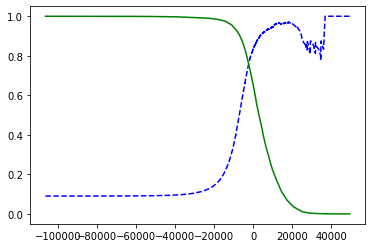

In [20]:
# 모든 임계값에 대해 정밀도와 재현율을 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [21]:
# argmax는 최댓값의 첫번째 인덱스를 반환. 여기서는 첫번째 True 값을 의미.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

# 임계값 설정 (점수가 3370보다 높은것들)
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

3370.0194991439557
[False False False ...  True False False]
0.9000345901072293
0.4799852425751706


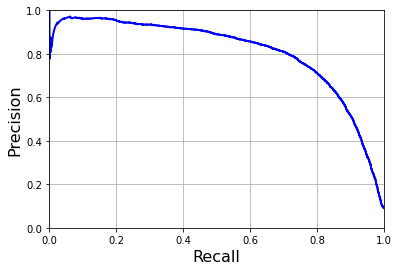

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()
# 곡선이 오른쪽 위에 가까워질수록 좋음

In [23]:
from sklearn.metrics import roc_curve

# fpr = 1 - tnr
# tpr = 재현율
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

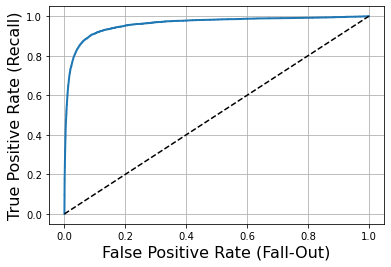

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plot_roc_curve(fpr, tpr)
plt.show()
# 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야함 (왼쪽 위)
# 점선은 완전 랜덤 분류기

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)
# 완벽한 분류기는 auc=1 (accuracy 아님)
# 완전 랜덤 분류기는 auc=0.5 (이진 분류기라서)

0.9604938554008616

양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할때 PR 곡선을 사용. (정밀도/재현율)
그렇지 않으면 ROC 사용.

예를 들어 방금전 ROC 곡선이 잘 나와서 좋은 분류기라고 생각할 수 있는데 이는 음성(5아님)에 비해 양성(5)이 크게 적기 때문이다.
이와는 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리) 잘 보여준다.


In [26]:
# 사이킷런은 일반적으로 decision_function() 또는 predict_proba() 메서드 둘 다 또는 둘 중 하나를 가지고있다.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method='predict_proba')
# predict_proba() 메서느는 샘플이 행, 클래스가 열이고
# 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환
# (어떤 이미지가 5일 확률 70%)
print(y_probas_forest)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


In [27]:
# roc_curve()는 레이블과 점수를 기대한다. 하지만 점수 대신 클래스 확률을 전달 할 수 있다.
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

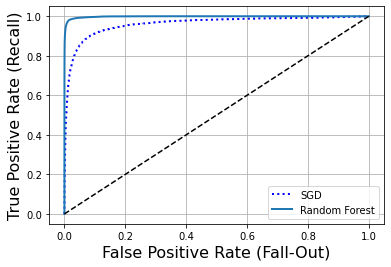

In [28]:
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [29]:
print(roc_auc_score(y_train_5, y_scores_forest))

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9983436731328145
0.9905083315756169
0.8662608374838591


다중 분류

In [30]:
# OvR : 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9)
# OvO : 0과 1 구별, 1과 2 구별 등 각 숫자의 조합마다 이진 분류기를 훈련. (OvO 장점, 각 분류기의 훈련에 두 클래스에 해당하는 샘플만 필요)
# SVM 빼고는 대부분 OvR 선호
# 사이킷런은 알고리즘에 따라 자동으로 OvO 또는 OvR 실행
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train 사용
svm_clf.predict([some_digit])
# 내부에서 사이킷런이 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택.

array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

print(np.argmax(some_digit_scores))

print(svm_clf.classes_)
print(svm_clf.classes_[5]) # svm_clf.classes_[np.argmax(some_digit_scores)]

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]
5


In [32]:
# 강제로 OvO나 OvR을 사용하는 법
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [33]:
print(len(ovr_clf.estimators_))

10


In [34]:
# SGDClissifier는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 OvR이나 OvO를 따로 적용할 필요 없음.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [35]:
# decision_function()은 클래스마다 하나의 값을 반환. SGD 분류기가 클래스마다 부여한 점수.
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [37]:
# 입력의 스케줄을 조정 (StandardScaler: 평균을 뺀 후 표준편차로 나누어 결과 분포의 분산이 1이 되도록함. (이상치에 덜 영향 받음))
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

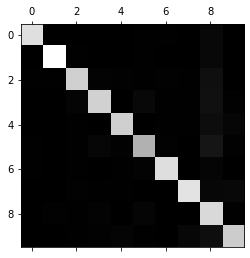

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)

norm_conf_mx = conf_mx / row_sums
print(norm_conf_mx)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[[9.41583657e-01 0.00000000e+00 3.71433395e-03 8.44166807e-04
  1.35066689e-03 7.25983454e-03 6.07800101e-03 1.01300017e-03
  3.79875063e-02 1.68833361e-04]
 [0.00000000e+00 9.49273213e-01 5.48798576e-03 3.55977455e-03
  5.93295758e-04 6.52625334e-03 5.93295758e-04 1.03826758e-03
  3.14446752e-02 1.48323939e-03]
 [4.53172205e-03 4.53172205e-03 8.76132931e-01 1.54414233e-02
  1.22524337e-02 4.53172205e-03 1.12453844e-02 6.04229607e-03
  6.34441088e-02 1.84625713e-03]
 [3.58832164e-03 2.77279400e-03 1.90833469e-02 8.52552602e-01
  3.26211059e-04 3.31104224e-02 4.40384929e-03 6.52422117e-03
  6.57315283e-02 1.19067036e-02]
 [2.05409106e-03 2.39643958e-03 7.01814447e-03 1.54056830e-03
  8.87024991e-01 2.05409106e-03 5.81992468e-03 4.62170490e-03
  5.93974666e-02 2.80725779e-02]
 [4.98063088e-03 2.76701716e-03 5.53403431e-03 3.09905921e-02
  9.77679395e-03 8.19774949e-01 1.38350858e-02 2.58254935e-03
  9.869027

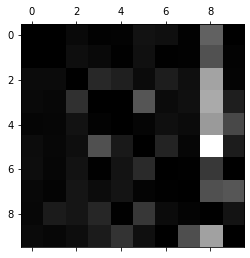

In [42]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

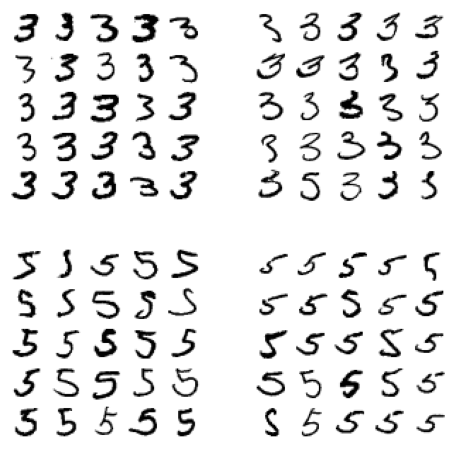

In [47]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()
# 왼쪽은 3으로 분류된 이미지, 오른쪽은 5라고 분류된 이미지

다중 레이블 분류 (Multilabel classification)

In [48]:
# 예) 앨리스, 밥, 찰리 얼굴 인식
# 엘리스와 찰리가 있는 이미지 -> [1, 0, 1]
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # np.c_ : 1차원 배열 2개를 붙여서 2차원으로 만듬 [1, 2, 3] [a, b, c] -> [[1, a]
                                                 #                                                                [2, b]
                                                 #                                                                [3, c]]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
# [큰 값(7,8,9)인지, 홀수인지]

KNeighborsClassifier()

In [ ]:
# 모든 레이블에 대한 F1 점수의 평균 (모든 레이블의 가중치가 같다고 가정)
# 앨리스 사진이 밥이나 찰리보다 많으면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둠.
# 간단한 방법은 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주는 것. -> average='weighted'
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='marco')

다중 출력 분류 (Multioutput multiclass classification)

In [ ]:
# 이미지 잡음 제거 분류기
# 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러개 가집니다.(0~255까지 픽셀 강도)

# 이미지 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# 정답은 원본 이미지
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Practice

In [ ]:
# 1
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# prepared data
full_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
])

X_train_prepared = full_pipeline.fit_transform(X_train.astype(np.float64))
X_test_prepared = full_pipeline.transform(X_test.astype(np.float64))
#

# hyper parameter tunning
param_grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5]
}

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)

grid_search.fit(X_train_prepared, y_train)
print(grid_search.best_param_)
print(grid_search.best_score_)
#

# model prediction
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_prepared)
#

# print result
print('Test set accuracy: ', metrics.accuracy_score(y_test, final_predictions))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, final_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_test, final_predictions))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn_clf, X_test_prepared, y_test, cv =5)
print('Model accuracy: ', np.sqrt(-scores))
#